**Univerisity of Pisa - M.Sc. Computer Science, Artificial Intelligence**  
**Intelligent system for pattern recognition - a.a. 2021/22**

**Author:** Irene Pisani - i.pisani1@studenti.unipi.it - matricola 560104  
**Date:** 14 April 2022

### **2° MIDTERM: assignment n°1**
# **SIGNAL PROCESSING: HIDDEN MARKOV MODEL AND VITERBI ALGORITHM**

***Abstract.*** *The main aim of this project is to fit some **Hidden Markov Models** with Gaussian emissions and different number of component to the Appliances consumption dataset and the Lights consumption dataset.* \
*Distinct HMMs with 2,3,4 and 5 hidden states have been trained for both datasets and for each HMM **Viterbi** was performed on a subsequence of 1 month of data.* \
*The final goal was **sampling** a sequence of 100 points from each available HMM and compare  (in a qualitative and quantitave manner) these generated data with the ground data in order to assess which distribution of new data is closest to the real distribution.*



---



## **1. Preliminary steps**

Python version 3.7 was used for this project.  
For the code below to work properly,  it is necessary to install **hmmlearn** version 0.2.7 and to import some auxiliary libraries.

In [ ]:
pip install hmmlearn

In [ ]:
import numpy as np
import pandas as pd
import cv2

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display

from hmmlearn.hmm import GaussianHMM 

import warnings
warnings.filterwarnings('ignore')

### **1.1 Energy Dataset: Lights consupmtion dataset and Appliances consumption dataset**

First of all, it is necessary  to upload from Github the required dataset [Appliances energy prediction Data Set](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction#) (UCI, Machine Learning Repository) and use it to create 2 useful dataset: one for Appliances and one for Lights.

Then, from each created dataset a sequence of one month of data (all measurements recorded in April 2016) has been derived to use it in Viterbi algorithm.

In [ ]:
!git clone https://github.com/irenepisani/ISPR.git

fatal: destination path 'ISPR' already exists and is not an empty directory.


In [ ]:
# read energy dataset as dataframe
energy_dataset = pd.read_csv('/content/ISPR/Midterm_2/energydata_complete.csv')
energy_dataset = energy_dataset.set_index("date")
display(energy_dataset)

# create 2 useful datasets: Appliance dataset and Lights dataset
appliances_dataset = energy_dataset.loc[:, ["Appliances"]]
lights_dataset     = energy_dataset.loc[:, ["lights"]]

# create 2 sequence on which to perform Viterbi alghoritm (these sequence are necessary in next step of the project)
# sequence are compose of all measure performed in one month (April 2016)
lights_sequence = lights_dataset['2016-04':'2016-05']
appliances_sequence = appliances_dataset['2016-04':'2016-05']

Appliances  lights         T1       RH_1         T2  \
date                                                                       
2016-01-11 17:00:00          60      30  19.890000  47.596667  19.200000   
2016-01-11 17:10:00          60      30  19.890000  46.693333  19.200000   
2016-01-11 17:20:00          50      30  19.890000  46.300000  19.200000   
2016-01-11 17:30:00          50      40  19.890000  46.066667  19.200000   
2016-01-11 17:40:00          60      40  19.890000  46.333333  19.200000   
...                         ...     ...        ...        ...        ...   
2016-05-27 17:20:00         100       0  25.566667  46.560000  25.890000   
2016-05-27 17:30:00          90       0  25.500000  46.500000  25.754000   
2016-05-27 17:40:00         270      10  25.500000  46.596667  25.628571   
2016-05-27 17:50:00         420      10  25.500000  46.990000  25.414000   
2016-05-27 18:00:00         430      10  25.500000  46.600000  25.264286   

                          RH_2         T3       RH_3         T4       RH_4  \
date                                                                         
2016-01-11 17:00:00  44.790000  19.790000  44.730000  19.000000  45.566667   
2016-01-11 17:10:00  44.722500  19.790000  44.790000  19.000000  45.992500   
2016-01-11 17:20:00  44.626667  19.790000  44.933333  18.926667  45.890000   
2016-01-11 17:30:00  44.590000  19.790000  45.000000  18.890000  45.723333   
2016-01-11 17:40:00  44.530000  19.790000  45.000000  18.890000  45.530000   
...                        ...        ...        ...        ...        ...   
2016-05-27 17:20:00  42.025714  27.200000  41.163333  24.700000  45.590000   
2016-05-27 17:30:00  42.080000  27.133333  41.223333  24.700000  45.590000   
2016-05-27 17:40:00  42.768571  27.050000  41.690000  24.700000  45.730000   
2016-05-27 17:50:00  43.036000  26.890000  41.290000  24.700000  45.790000   
2016-05-27 18:00:00  42.971429  26.823333  41.156667  24.700000  45.963333   

                     ...         T9     RH_9      T_out  Press_mm_hg  \
date                 ...                                               
2016-01-11 17:00:00  ...  17.033333  45.5300   6.600000        733.5   
2016-01-11 17:10:00  ...  17.066667  45.5600   6.483333        733.6   
2016-01-11 17:20:00  ...  17.000000  45.5000   6.366667        733.7   
2016-01-11 17:30:00  ...  17.000000  45.4000   6.250000        733.8   
2016-01-11 17:40:00  ...  17.000000  45.4000   6.133333        733.9   
...                  ...        ...      ...        ...          ...   
2016-05-27 17:20:00  ...  23.200000  46.7900  22.733333        755.2   
2016-05-27 17:30:00  ...  23.200000  46.7900  22.600000        755.2   
2016-05-27 17:40:00  ...  23.200000  46.7900  22.466667        755.2   
2016-05-27 17:50:00  ...  23.200000  46.8175  22.333333        755.2   
2016-05-27 18:00:00  ...  23.200000  46.8450  22.200000        755.2   

                        RH_out  Windspeed  Visibility  Tdewpoint        rv1  \
date                                                                          
2016-01-11 17:00:00  92.000000   7.000000   63.000000   5.300000  13.275433   
2016-01-11 17:10:00  92.000000   6.666667   59.166667   5.200000  18.606195   
2016-01-11 17:20:00  92.000000   6.333333   55.333333   5.100000  28.642668   
2016-01-11 17:30:00  92.000000   6.000000   51.500000   5.000000  45.410389   
2016-01-11 17:40:00  92.000000   5.666667   47.666667   4.900000  10.084097   
...                        ...        ...         ...        ...        ...   
2016-05-27 17:20:00  55.666667   3.333333   23.666667  13.333333  43.096812   
2016-05-27 17:30:00  56.000000   3.500000   24.500000  13.300000  49.282940   
2016-05-27 17:40:00  56.333333   3.666667   25.333333  13.266667  29.199117   
2016-05-27 17:50:00  56.666667   3.833333   26.166667  13.233333   6.322784   
2016-05-27 18:00:00  57.000000   4.000000   27.000000  13.200000  34.118851   

                           rv2  
date               



---


## **2. Fit different HMMs to Appliances and Lights datasets**



The first aim was to fit some HMMs to the available datasets.

`applyModel()` is a 3-parameter function useful for training HMMs with different numbers of component, for applying the Viterbi algorithm and for generating new samples. 
This function involves several steps:
1. The construction of an Hidden Markov Model with Gaussian emission by means of the `GaussianHMM()` constructor provided by the `hmmlearn` library; different HMMs were constructed by changing the value of the `n_component` attribute (this attribute is a hyperparameter that defines the number of hidden states of the model).
2. Fitting the model to the employed dataset using the `fit()` function.
3. Storage of additional information (to be investigated later) such as the transition matrix (`transmat_`) and likelihood (`score()`) obtained from the model.
4. Execution of the Viterbi algorithm on a predefined sequence provided in input through `predict()` function (more details on the Viterbi results can be found in section 3).
5. Sampling of new data using the `sample()` function (more details on sampling results can be found in section 4).


In [ ]:
def applyModel (dataset, n_hidden_state, sequence):
  
  # Use constructor to built Hidden Markov Model with Gaussian Emission and with a given number of hidden states
  hm_model = GaussianHMM(n_components=n_hidden_state, covariance_type="diag", n_iter=100, algorithm="viterbi")
  # Fit the model to dataset (lights dataset or appliances dataset)
  hm_model.fit(dataset)

  transition_matrix = hm_model.transmat_ # obtain Tranisition Matrix
  likelihood = hm_model.score(dataset)   # obtain Likelihood 
  mean = hm_model.means_                 # obtain means

  # obtain the inferred optimal hidden states using Viterbi alghorithm for a sequence o 1 month of data
  hidden_state = hm_model.predict(sequence)

  # sampling a sequence of 100 point
  X, Z = hm_model.sample(100)

  #sampling a squence of 100 point 50 times (to get acccurate score of KL diverenge -> ref. section 5)
  sample_X = []
  for i in range(50):
    X_, _ = hm_model.sample(100)
    sample_X.append(X_)

  return transition_matrix, likelihood, hidden_state, X, Z, mean, sample_X

`applyModel()` was performed in parallel over the two available dataset:


*  **Appliances dataset.** Different HMMs with 2, 3, 4, and 5 hidden states were created and fitted to `appliances_dataset`, then viterbi was performed on `appliances_sequence` given in input, and all obtained results were returned.
*   **Lights dataset.** Different HMMs with 2, 3, 4, and 5 hidden states were created and fitted to `lights_dataset`, then viterbi was performed on  `lights_sequence` given in input and all obtained results were returned.

Both sequences used in Viterbi are composed by all measurements taken in April 2016.


In [ ]:
# ------- Appliance dataset -------

# apply different HMM (with 2, 3, 4 and 5 hidden states) to appliances dataset
transitionM_2, likelihood_2, hidden_states_2, X2, Z2, mean2, sample_X2 = applyModel(appliances_dataset, 2, appliances_sequence)
transitionM_3, likelihood_3, hidden_states_3, X3, Z3, mean3, sample_X3 = applyModel(appliances_dataset, 3, appliances_sequence)
transitionM_4, likelihood_4, hidden_states_4, X4, Z4, mean4, sample_X4 = applyModel(appliances_dataset, 4, appliances_sequence)
transitionM_5, likelihood_5, hidden_states_5, X5, Z5, mean5, sample_X5 = applyModel(appliances_dataset, 5, appliances_sequence)

A_transitionM = np.array([transitionM_2, transitionM_3, transitionM_4, transitionM_5])         # store transition matrix of each HMM
A_likelihood  = np.array([likelihood_2, likelihood_3, likelihood_4, likelihood_5])             # store likelihood of each HMM
A_hiddenstate = np.array([hidden_states_2, hidden_states_3, hidden_states_4, hidden_states_5]) # store viterbi hidden state sequence of each HMM
A_sampleX = np.array([X2, X3, X4, X5])    # store transition matrix of each HMM
A_sampleZ = np.array([Z2, Z3, Z4, Z5])    # store transition matrix of each HMM
A_mean = np.array([mean2, mean3, mean4, mean5])   # store transition matrix of each HMM
A_sample_X = np.array([sample_X2, sample_X3, sample_X4, sample_X5]) # store more sample of each HMM
# ------- Lights dataset -------

# apply different HMM (with 2, 3, 4 and 5 hidden states) to appliances dataset
transitionM_2, likelihood_2, hidden_states_2, X2, Z2, mean2, sample_X2 = applyModel(lights_dataset, 2, lights_sequence)
transitionM_3, likelihood_3, hidden_states_3, X3, Z3, mean3, sample_X3 = applyModel(lights_dataset, 3, lights_sequence)
transitionM_4, likelihood_4, hidden_states_4, X4, Z4, mean4, sample_X4 = applyModel(lights_dataset, 4, lights_sequence)
transitionM_5, likelihood_5, hidden_states_5, X5, Z5, mean5, sample_X5 = applyModel(lights_dataset, 5, lights_sequence)

L_transitionM = np.array([transitionM_2, transitionM_3, transitionM_4, transitionM_5])         # store transition matrix of each HMM
L_likelihood  = np.array([likelihood_2, likelihood_3, likelihood_4, likelihood_5])             # store likelihood of each HMM
L_hiddenstate = np.array([hidden_states_2, hidden_states_3, hidden_states_4, hidden_states_5]) # store viterbi hidden state sequence of each HMM
L_sampleX = np.array([X2, X3, X4, X5])    # store of sample generated with each HMM
L_sampleZ = np.array([Z2, Z3, Z4, Z5])    # store of sample generated with each HMM
L_mean = np.array([mean2, mean3, mean4, mean5])   # store hidden state means of each HMM
L_sample_X = np.array([sample_X2, sample_X3, sample_X4, sample_X5]) # store more sample of each HMM

### **2.1 Transition matrix and Likelihood analysis from different trained HMMs**

Considering the elements of the HMMs Transition Matrices we can find the probability of moving from one state to another. \
Considering Likelihood scores obtained from HMMs trained over Appliances and Lights dataset we can say that for both datasets the likelihood values seem to be directly proportional to the number of hidden states of the model.

In [ ]:
print("Dataset: APPLIANCES")
for i in range(4):
  print("\n HMM with "+str(i+2)+" hidden states:")
  print("Transition Matrix: \n", A_transitionM[i])
  print("Likelihood: ", A_likelihood[i]) 

Dataset: APPLIANCES

 HMM with 2 hidden states:
Transition Matrix: 
 [[0.9730353  0.0269647 ]
 [0.05926382 0.94073618]]
Likelihood:  -97986.85180953555

 HMM with 3 hidden states:
Transition Matrix: 
 [[0.97016469 0.01159383 0.01824149]
 [0.02264826 0.80507675 0.17227499]
 [0.05091614 0.06786138 0.88122248]]
Likelihood:  -91386.03310841498

 HMM with 4 hidden states:
Transition Matrix: 
 [[9.69909659e-01 1.10231749e-02 9.07063674e-04 1.81601024e-02]
 [3.15999425e-02 6.70124748e-01 7.71964294e-02 2.21078880e-01]
 [4.27408581e-07 3.50643038e-01 6.22913967e-01 2.64425669e-02]
 [5.11064273e-02 5.65244610e-02 1.53004734e-02 8.77068638e-01]]
Likelihood:  -90890.64229496446

 HMM with 5 hidden states:
Transition Matrix: 
 [[9.63542958e-01 8.75918724e-03 2.63037797e-02 8.04777696e-04
  5.89296959e-04]
 [2.45368453e-02 6.53403605e-01 6.95355414e-02 1.74296538e-01
  7.82274707e-02]
 [8.04454744e-02 4.57645414e-02 8.22667157e-01 4.58278638e-02
  5.29496306e-03]
 [5.90147648e-03 5.81246063e-02 7.8

In [ ]:
print("Dataset: LIGHTS")
for i in range(4):
  print("\n HMM with "+str(i+2)+" hidden states:")
  print("Transition Matrix:", L_transitionM[i])
  print("Likelihood: ", L_likelihood[i]) 

Dataset: LIGHTS

 HMM with 2 hidden states:
Transition Matrix: [[0.91955602 0.08044398]
 [0.27373867 0.72626133]]
Likelihood:  72094.82919896388

 HMM with 3 hidden states:
Transition Matrix: [[0.91955155 0.00793347 0.07251498]
 [0.04667393 0.79396502 0.15936105]
 [0.50703249 0.15646323 0.33650428]]
Likelihood:  90675.16566127805

 HMM with 4 hidden states:
Transition Matrix: [[0.91955153 0.0061631  0.07251508 0.00177028]
 [0.05418739 0.53078382 0.19211915 0.22290963]
 [0.50701041 0.13342352 0.33649932 0.02306675]
 [0.02782066 0.57650165 0.07727938 0.31839832]]
Likelihood:  102940.8956365986

 HMM with 5 hidden states:
Transition Matrix: [[5.30788179e-01 5.41871923e-02 1.92118227e-01 2.14285495e-01
  8.62090701e-03]
 [6.16312612e-03 9.19551535e-01 7.25150797e-02 1.70469238e-03
  6.55672376e-05]
 [1.33423790e-01 5.07010405e-01 3.36499319e-01 2.08049703e-02
  2.26151550e-03]
 [6.47594470e-01 3.04118788e-02 7.69238720e-02 1.86038965e-01
  5.90308140e-02]
 [1.24990819e-01 1.13627722e-02 7.



---


## **3. Insights into Viterbi results**




As previously mentioned, the Viterbi algorithm was run over a timeserie (extracted from the considered dataset) in order to obtain for each observation in timeserie the hidden state which is inferred to be optimal. 

The Viterbi sequences obtained for the two datasets are respectively stored in the variables `A_hiddenstate` for appliances and `L_hiddenstates` for lights. 

In this phase, another goal of the project was to plot the timeseries (the subsequence previously chosen) highlighting the hidden state assigned to each timepoint by the Viterbi algorithm: for this purpose the function `highlightHiddenState()` has been implemented.

This function returns a plot for each trained HMMs. In every plot, each possible hidden state was represented by a unique colour and each observation shown in graph was coloured with the colour corresponding to the hidden state predicted by Viterbi.


In [ ]:
def conditions(x):
  #associates a unique colour with each possible hidden state
  if x == 0: 
    return "r" # 0° HS -> red
  elif x ==1:
    return "b" # 1° HS -> blu
  elif x ==2:
    return "g" # 2° HS -> red
  elif x ==3:
    return "y" # 3° HS -> yellow
  else:
    return "c" # 4° HS -> cyan

def highlightHiddenState (sequence, hidden_states, temp):

  # substitute sequence of hidden state with sequence of corresponding colour
  # this operation decide how to color the point in series
  color_point_2 = np.vectorize(conditions)(hidden_states[0])
  color_point_3 = np.vectorize(conditions)(hidden_states[1])
  color_point_4 = np.vectorize(conditions)(hidden_states[2])
  color_point_5 = np.vectorize(conditions)(hidden_states[3])

  plt.rcParams['figure.figsize'] = [18, 12]
  plt.rcParams['figure.dpi'] = 300
  
  # scatter points in timeseries (=c hoosen sequence) highlighting the corresponding inferred optimal hidden states
  fig, axs = plt.subplots(nrows=2,ncols=2)
  fig.suptitle("\n Optimal inferred Hidden State (HS) for point in timeserie for "+ temp +" dataset", fontweight="bold")
  
  for i in range(2):
    axs[0][i].set_xlabel('Point in timeserie from 1 April 2016 to 30 April 2016')
    axs[0][i].set_ylabel('Point value')
    axs[0][i].tick_params(labelbottom = False, bottom = False)
    axs[1][i].set_xlabel('Point in timeserie from 1 April 2016 to 30 April 2016')
    axs[1][i].set_ylabel('Point value')
    axs[1][i].tick_params(labelbottom = False, bottom = False)

  #plt.tick_params( axis='x', which='both', bottom=False,top=False, labelbottom=False)
  axs[0][0].set_title("(a) HMM with 2 HS ")
  axs[0][0].scatter(sequence.index, sequence[temp], marker='.', s=10, c=color_point_2)
  axs[0][1].set_title("(b) HMM with 3 HS ")
  axs[0][1].scatter(sequence.index, sequence[temp], marker='.', s=10, c=color_point_3)
  axs[1][0].set_title("(c) HMM with 4 HS ")
  axs[1][0].scatter(sequence.index, sequence[temp], marker='.', s=10, c=color_point_4)
  axs[1][1].set_title("(d) HMM with 5 HS ")
  axs[1][1].scatter(sequence.index, sequence[temp], marker='.', s=10, c=color_point_5)

  # add legend to figure
  classes = ["0° HS" ,"1° HS","2° HS","3° HS","4° HS"]
  class_colours = ['r','b','g','y','c']
  recs = []
  for i in range(0,len(class_colours)):
      recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
  plt.legend(recs,classes, bbox_to_anchor=(1.01, 1.0, 0.3, 0.2), loc='upper left ')
  plt.show()

  return

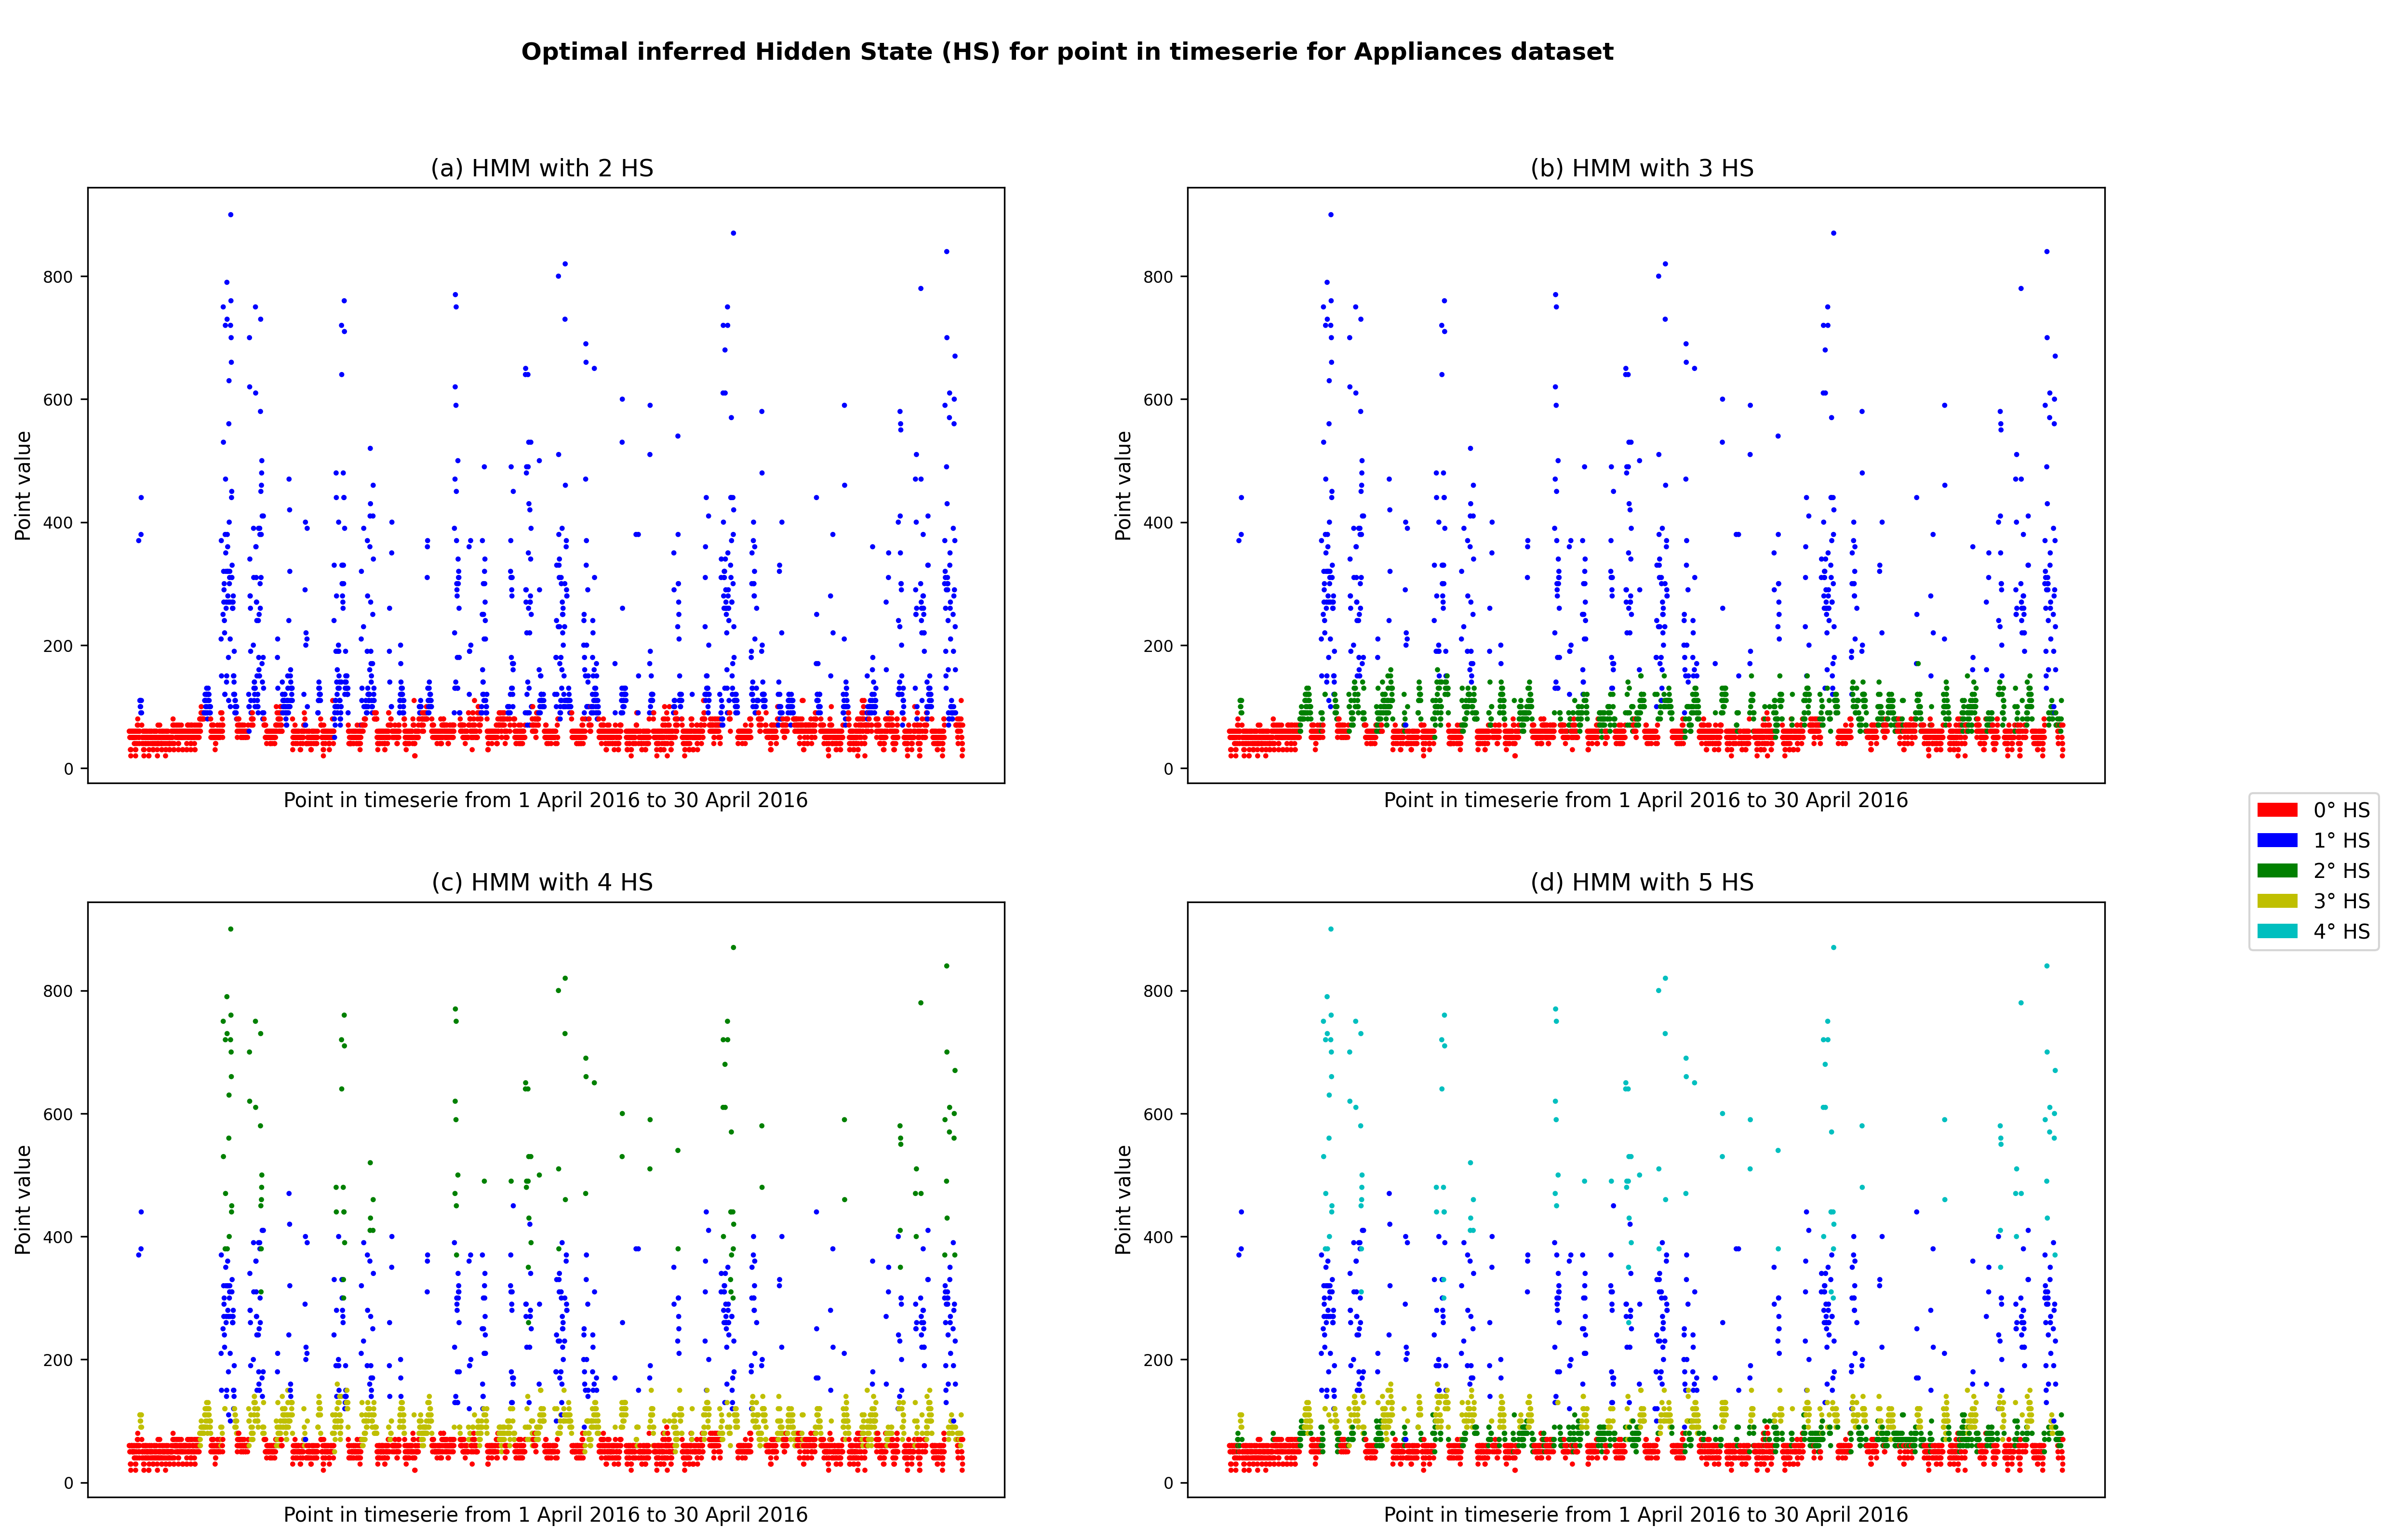

In [ ]:
highlightHiddenState (appliances_sequence, A_hiddenstate, "Appliances")

Looking at the image above we can say that for the **Appliances** dataset the points with similar values are coloured with the same colour, or rather, are associated with the same hidden state. 

In particular, looking at the scattered points in the figure we can see that the amount of points with a low value is greater than the amount of points with a high value and we can also deduce the following statements.

- Using an HMMs with 2 hidden states we have 2 possible colours to highlight points in serie (in other world 2 possible hidden states to associate with each point). We can observe that the points having low values are coloured with a first colour while all the remaining points, having higher values, are coloured with a second one.

- Using an HMMs with 3 hidden states we have 3 colours available. One colour is used for those points having values close to the minimum value; another colour is used for those points having low values and the last colour is used for those points having higher values.

- Using an HMMs with 4 hidden states we have 4 colours available. A first colour is used for those points having values close to the minimum value; two of the remaining colours are used for those points having low and high values respectively. The last colour is used for points having values close to the maximum value. 

- Using an HMMs with 5 hidden states we have 5 colours available. In this case one colour is used to highlight points close to the minimum value and one colour is used to highlight points close to the maximum value. Finally, a third colour is used to highlight points with medium values, while the remaining two colours are used to colour points with low and high values respectively. 

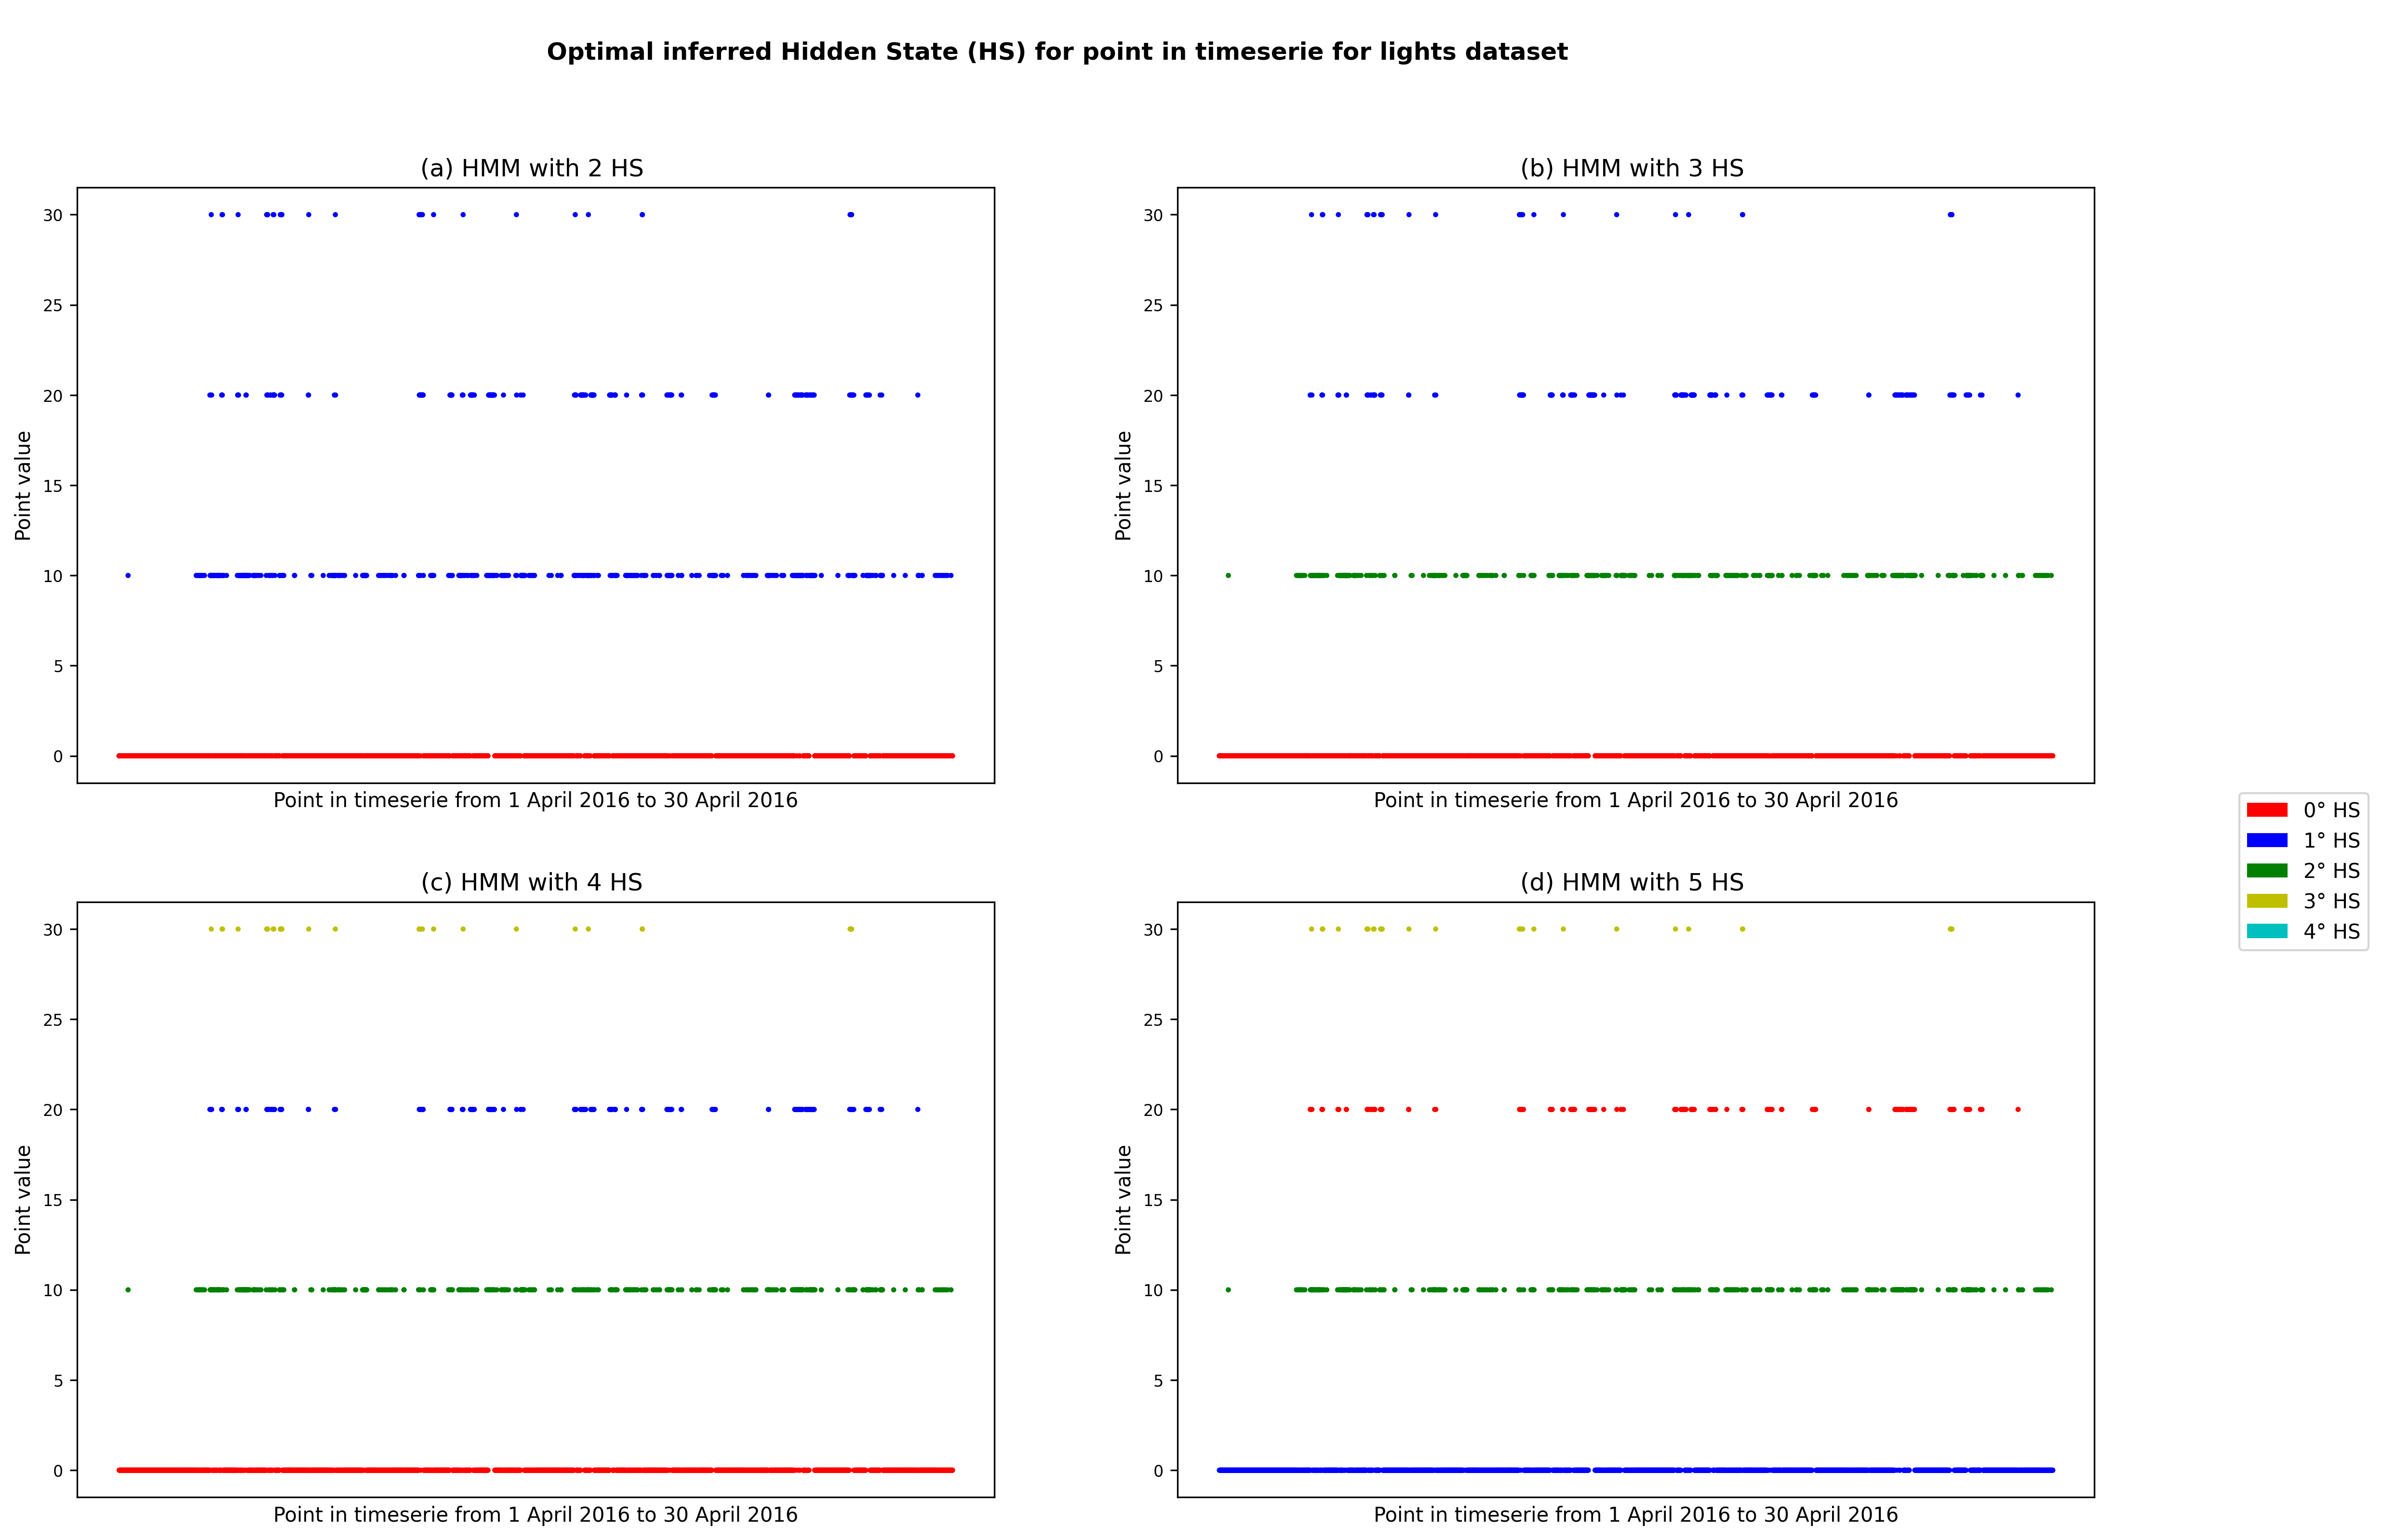

In [ ]:
highlightHiddenState (lights_sequence, L_hiddenstate, "lights")

Looking at the above image we can state that for **lights** dataset the points in timeseries with equal values are coloured with the same colour, or rather, are associated with the same hidden state. 

In particular, observing that the points in the extracted sequence have only 4 possible values (which is why the points are arranged on 4 parallel lines) we can make the following statements:

- Using an HMMs with 2 hidden states we have 2 possible colours to highlight the points in serie, i.e. 2 possible hidden states to associate with each point. We can observe that the points having a minimum value (equal to 0) are coloured with a certain colour while all the remaining points having values greater than 0 are coloured with another colour. 
- Using an HMMs with 3 hidden states we have 3 colours available. One colour is used for the points having the smallest value (value equal to 0), one colour is used for those points having the second smallest value (equal to 10), and the third colour highlights those points having the 2 possible largest values (20 or 30).
- Using an HMMs with 4 hidden states we have 4 colours available. In this case each colour is used to highlight those points having the same value.
- Using an HMMs with 4 hidden states we have 5 colours available. Here, 4 of the possible colours are used to colour each of the points associated with the hidden state they represent (as in the previous case of HMMs with 4 hidden states). However, the fifth colour is not used to represent any point in the serie, i.e. there is an hidden state which has not been inferred to be optimal for any of the points in the sequence.

### **3.1 Detection of different consumption level**

From the previous study we deduce the possibility of associating each hidden state to a specific level or range of consumption; this is possible for both datasets.

In order to better analyse the different levels of consumption identified by the hidden states of each considered HMM, we refer to the average value of hidden states.

The `DetectConsumptionLevel()` function returns an heatmap where, for each HMMs, its hidden states are coloured in a way corresponding to the average value of the state. In particular:
- Hidden states coloured in red represent max level of consumption;
- Hidden states coloured in yellow or orange represent high level of consumption;
- Hidden states coloured in green or blue represent low levels of consumption;
- Hidden states coloured in purple represent minimum levels of consumption.

Looking at the two figures below, we can identify more clearly different levels of consumption for light data than for appliances data; however, distinct levels of consumption can also be seen when looking to appliances data.

In [ ]:
def DetectConsumptionLevel(mean, data):
  
  # create a matrix of means of each hidden state 
  meanM = np.empty((4,5))
  #handle 0 mean in light to apply mask isnull()
  if data =="lights":
    for i in range(len(mean)):
      np.place(mean[i], mean[i] == 0, 1)

  for i in range(len(mean)):
    temp = np.concatenate(mean[i], None)
    temp.resize(5) 
    meanM[i]=temp
    # (ex) HMM with 2 hs could not have a mean value for the 3°, 4°, 5° hs 
    # put this value to nan in order to not show them in heatmap

  meanM[meanM == 0] = 'nan'
  meanM[meanM == 1] = 0

  # create dataframe
  df = pd.DataFrame(meanM, columns=["1° HS", "2° HS","3° HS","4° HS", "5° HS"])
  df = df.transpose()
  
  # plot heatmap to identify which hidden state in each HMM represent the highest/lowest level of consumption
  plt.rcParams['figure.figsize'] = [15, 12]
  plt.rcParams['figure.dpi'] = 100

  mask = df.isnull() # use mask to not consider nan mean hidden state of a certain HMM
  ax = sns.heatmap(df, mask=mask, annot=True,  fmt="g", cmap="Spectral_r", linewidths=.5)
  ax.set_title('\n Detection of Consumption Level for '+str(data)+ ' dataset: hidden states mean value for different HMM \n', fontweight="bold")
  ax.set_xlabel('Hidden Markov Model (HMM)')
  ax.xaxis.set_label_position('top') 
  ax.yaxis.set_label_position('left') 
  ax.set_ylabel('Hidden State (HS)')
  ax.xaxis.set_ticklabels(['2hs HMM ', '3hs HMM', '4hs HMM' , '5hs HMM'])
  plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = True, labeltop=True)
  plt.show()
  
  return


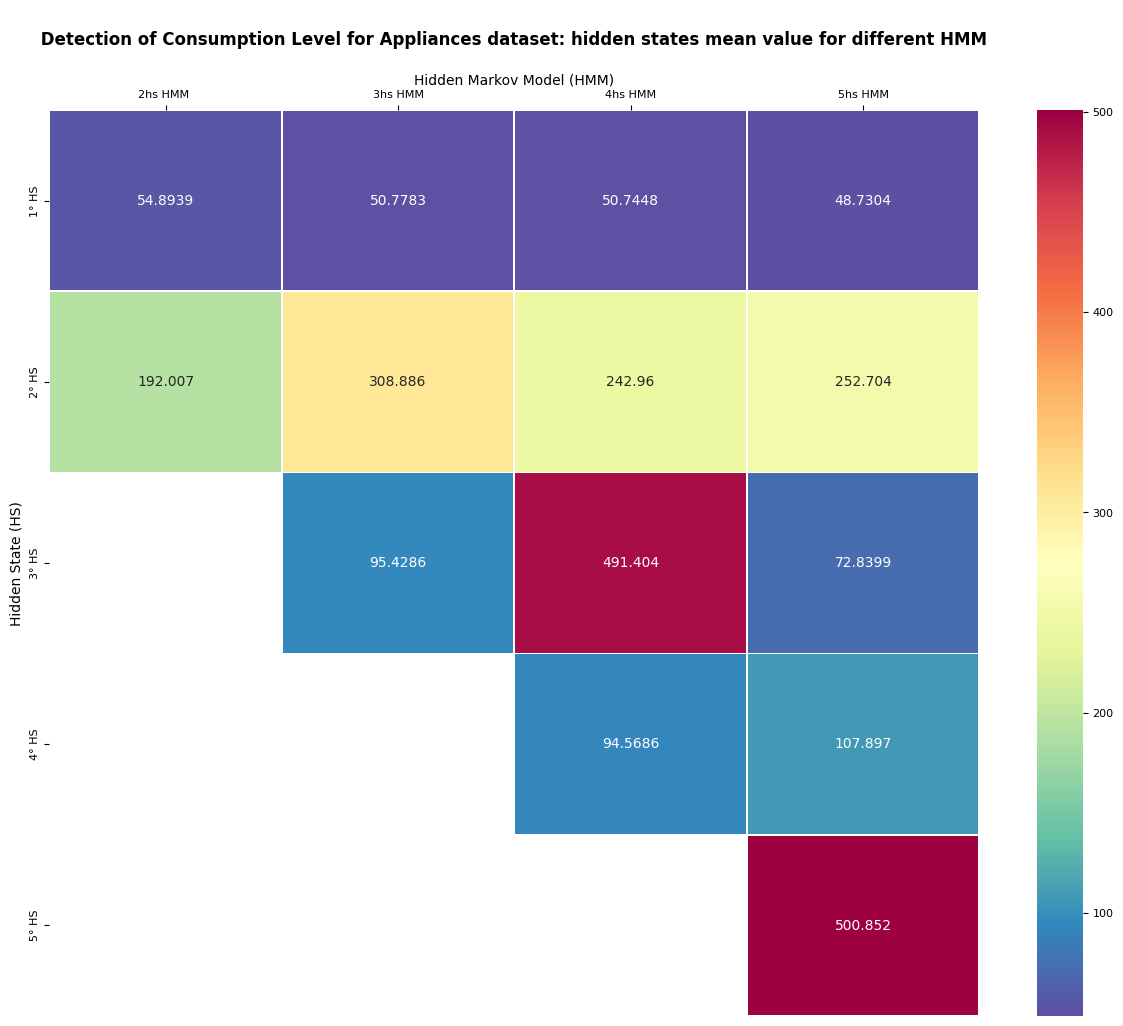

In [ ]:
DetectConsumptionLevel (A_mean, "Appliances")

For **Appliances** dataset Viterbi assigns the following level of consumption to each HMM:
- for 2 component HMM, we can find a minimum level and a low one;
- for 3 component HMM, we can find a minimum level, a low one and an high one;
- for 4 component HMM, we can find minimum, low, high and maximim levels;
- for 5 component HMM, we can find a minimum level, 2 low ones, an high one and a maximum level.


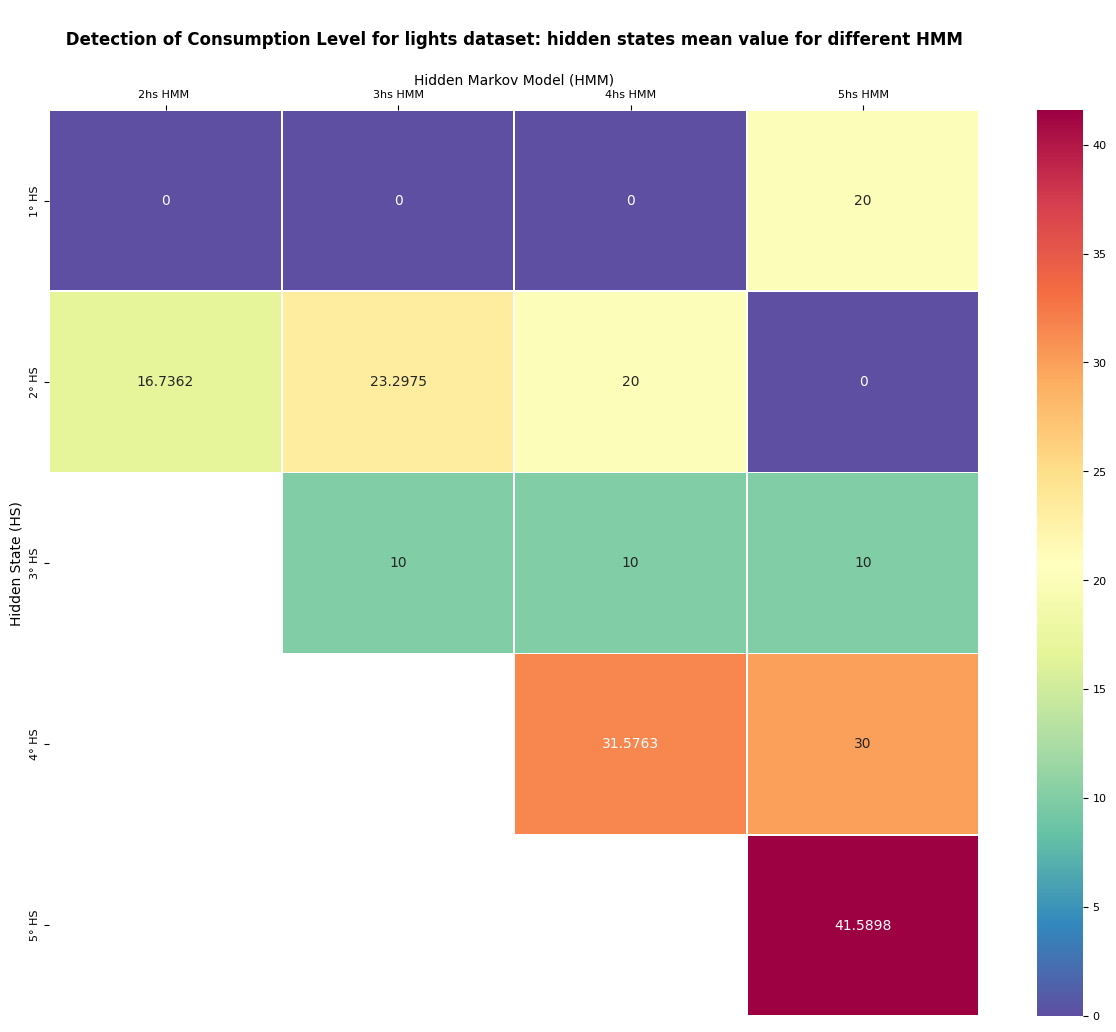

In [ ]:
DetectConsumptionLevel (L_mean, "lights")

For **Lights** dataset Viterbi assigns the following level of consumption to each HMM:
- for 2 component HMM, we can find a minimum level and a low one;
- for 3 component HMM, we can find a minimum level, a low one and an high one;
- for 4 component HMM, we can find minimum, low, high and maximum levels;
- for 5 component HMM, we can find a minimum level, a low one, 2 high one and a maximum level.



---


## **4. Insight into sampling results**

As already seen in section 2, the `applyModel()` function was also used to sample multiple sequences (each consisting of 100 points) with HMMs differing one form each other in the number of components. 

This section has the objective of taking 4 random sequences of sample data, each one produced with a specific HMM, to study (visually) how the different number of components can impact on the composition of the generated sequences. 

To this porpuse the function `analyzeSample()` has been implemented; it returns for each generated sequence:
1. a graph showing in parallel the series of generated points and the series of corresponding hidden states;
2. a graph showing the points of the sequence, colouring each point with a specific colour for its corresponding hidden state;
3. an histogram showing frequency of value in sequence;
4. the Kernel Density Estimation function (KDE) of the sequence.


In [ ]:
def analyzeSample (sampleX, sampleZ, temp):
  
  plt.rcParams['figure.figsize'] = [18, 15]
  plt.rcParams['figure.dpi'] = 500
  plt.rcParams['xtick.labelsize'] = 8 
  plt.rcParams['ytick.labelsize'] = 8

  fig, axs = plt.subplots(nrows=4,ncols=4)
  fig.suptitle("\n Samples generated for "+ temp+" dataset", fontweight="bold")
  
 # consider 4 sequence generated with our 4 available HMMs 
  for i in range(4): # for each sequence
    # plot X (=value of generated point) e Y(= corresponding hidden state) of the sequence
    axs[0][i].plot(sampleX[i], label="point in serie")
    axs[0][i].plot(sampleZ[i]*10, label="hidden state")
    axs[0][i].set_ylabel("Value")
    axs[0][i].set_xlabel("Sample")
    
    # plot point in sequence highlighting with specific color the corresponding hs
    axs[1][i].scatter(range(100), sampleX[i], marker='.', s=10, c=np.vectorize(conditions)(sampleZ[i]))
    axs[1][i].set_ylabel("Value")
    axs[1][i].set_xlabel("Sample")
    
    sample = pd.DataFrame(sampleX[i], columns=[temp])
    
    # plot histogram of frequencies of the point value
    sample[temp].plot(ax=axs[2][i], kind='hist', label='Generated sample')
    axs[2][i].set_xlabel("Sample Value")
    
    # plot kernel density estimation (kde)
    sample[temp].plot(ax=axs[3][i], kind='kde', label='Generated sample')
    axs[3][i].set_xlabel("Sample Value")

  axs[0][3].legend(bbox_to_anchor=(1.0, 0.5, 0.3, 0.2), loc='upper left ')

  classes = ["0° HS" ,"1° HS","2° HS","3° HS","4° HS"]
  class_colours = ['r','b','g','y','c']
  recs = []
  for i in range(0,len(class_colours)):
      recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
  axs[1][3].legend(recs,classes, bbox_to_anchor=(1.05, 0.5, 0.3, 0.2), loc='upper left ')

  for ax, col in zip(axs[0,:], ['(a) 2 hidden state HMM', '(b) 3 hidden state HMM', '(c) 4 hidden state HMM', '(d) 5 hidden state HMM']):
    ax.annotate(col, (0.5, 1), xytext=(0, 10), ha='center', va='bottom',
                xycoords='axes fraction', textcoords='offset points')

  plt.show()
  return

In [ ]:
# Dataset: APPLIANCES
analyzeSample(A_sampleX, A_sampleZ, "Appliances")

In [ ]:
# Dataset: LIGHTS
analyzeSample(L_sampleX, L_sampleZ, "Lights")



---


## **5. Comparison between samples and ground data**

Our trained HMMs, like any other generative models, have already generated data that follows the same distribution of the input dataset that we are modeling. The next goal want to identify the model able to generate data that better reflect the original distriution. 

This section focuses on the qualitative and quantitative comparison between these new generated data and true ground data.

### **5.1 Qualitative comparison: visual analysis of value's frequecies and KDE**

The `qualitativeAnalysis()` function allows us to compare the data sampled with each HMM with the real data. In fact, the function returns two graphs that can be used to study which of the obtained sequences is the most similar to the real data:
- The first graph shows the overlapping histograms of value's frequencies. This  visualization method represents the distribution of values in sequence by counting the number of observations that fall within disrete bins. Here, all histogram showed in the graph were normalize such that bar heights sum to 100 in order to simplify visual comparison between histograms; this normalization is recommended due to different lenght of sequences (true data sequence is composed by a greater number of observation).
- The second graph shows the overlapping Probability Density Functions estimated in a non-parametric way by means of kernel density estimate (KDE). KDE plot is a method for visualizing the distribution of observations in a sequence and it represents the data using a continuous probability density curves that are less cluttered and more interpretable with respect to histograms.

In [ ]:
def qualitativeAnalysis (sampleX, dataset, temp):
  
  plt.rcParams['figure.figsize'] = [18, 9]
  plt.rcParams['figure.dpi'] = 200

  sample_2 = pd.DataFrame(sampleX[0], columns=[temp])
  sample_3 = pd.DataFrame(sampleX[1], columns=[temp])
  sample_4 = pd.DataFrame(sampleX[2], columns=[temp])
  sample_5 = pd.DataFrame(sampleX[3], columns=[temp])
  
  fig, axs = plt.subplots(1,2)
  fig.suptitle("\n Visual comparison between generated sample and ground data for "+temp+" dataset\n", fontweight="bold")
  
  # GRAPH 1) plot overlapping histogram the frequency of each range of value use in point sequence 
  # nb. histograms are normalized in percentage in way to handle differet lenght sequences
  sns.histplot(sample_2[temp], ax=axs[0], stat="percent", color="lightskyblue", alpha=0.1, label="2 HMM", element="step", binwidth=10)
  sns.histplot(sample_3[temp], ax=axs[0], stat="percent", color="wheat", alpha=0.1, label="3 HMM", element="step", binwidth=10)
  sns.histplot(sample_4[temp], ax=axs[0], stat="percent", color="plum", alpha=0.1, label="4 HMM", element="step", binwidth=10)
  sns.histplot(sample_5[temp], ax=axs[0], stat="percent", color="lightgreen",  alpha=0.1, label ="5 HMM", element="step", binwidth=10)
  sns.histplot(dataset[temp], ax=axs[0], stat="percent", color="red",  alpha=0.1, label="Ground data", element="step", binwidth=10)
  if temp =="lights":
    axs[1].set_xlim(-20,60)
  else:
    axs[1].set_xlim(-100,600)
  axs[0].legend(loc=0)
  
  # GRAPH 2) plot overlapping kernel density function
  sns.kdeplot(sample_2[temp], ax=axs[1], color="lightskyblue", shade=True, alpha=0.1, label="2 HMM")
  sns.kdeplot(sample_3[temp], ax=axs[1], color="wheat", shade=True, alpha=0.1, label="3 HMM")
  sns.kdeplot(sample_4[temp], ax=axs[1], color="plum", shade=True, alpha=0.1, label="4 HMM")
  sns.kdeplot(sample_5[temp], ax=axs[1], color="lightgreen", shade=True, alpha=0.1, label ="5 HMM")
  sns.kdeplot(dataset[temp], ax=axs[1], color="red", shade=True, alpha=0.1, label="Ground data")
  if temp =="lights":
    axs[0].set_xlim(-20,60)
  else:
    axs[0].set_xlim(-100,600)
  axs[1].legend(loc=0)
  

  axs[0].set_title("(a) Compare values frequency ")
  axs[1].set_title("(b) Compare Kernel Desity Function ")
  axs[0].set_xlabel("Values")
  axs[1].set_xlabel("Values")
  plt.show()

  return 

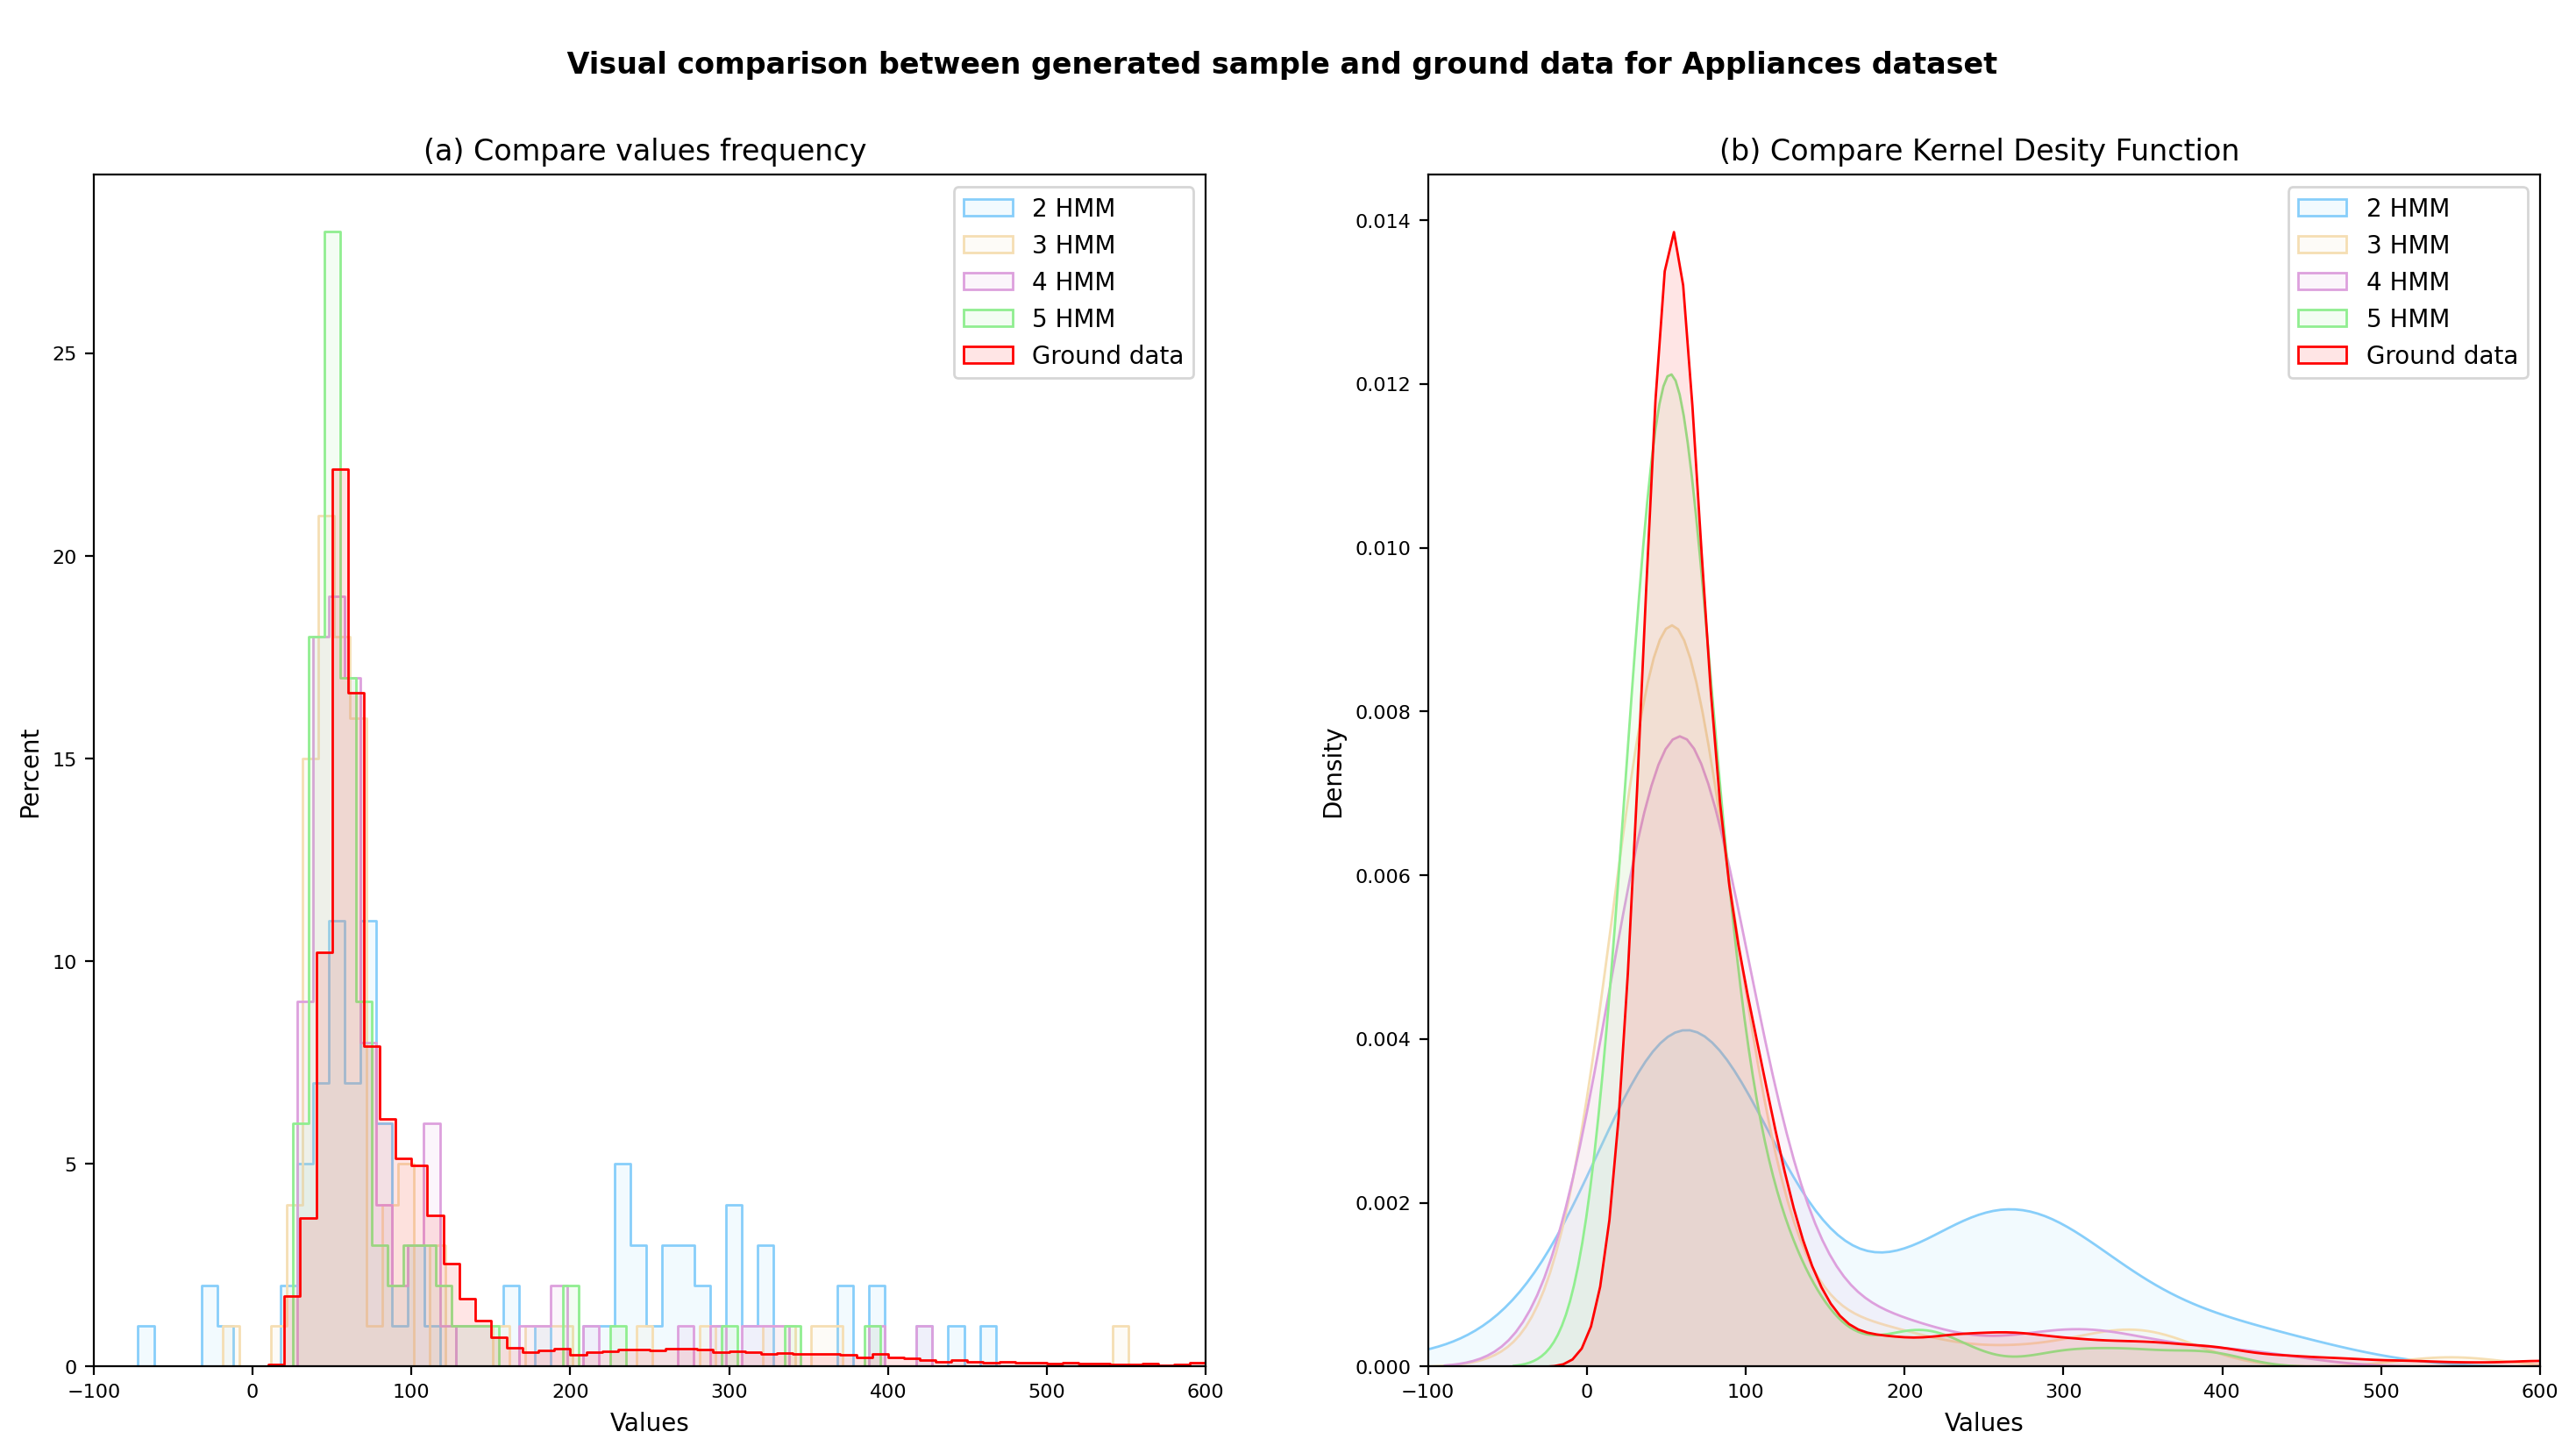

In [ ]:
# Dataset: APPLIANCES
qualitativeAnalysis (A_sampleX, appliances_dataset, "Appliances")

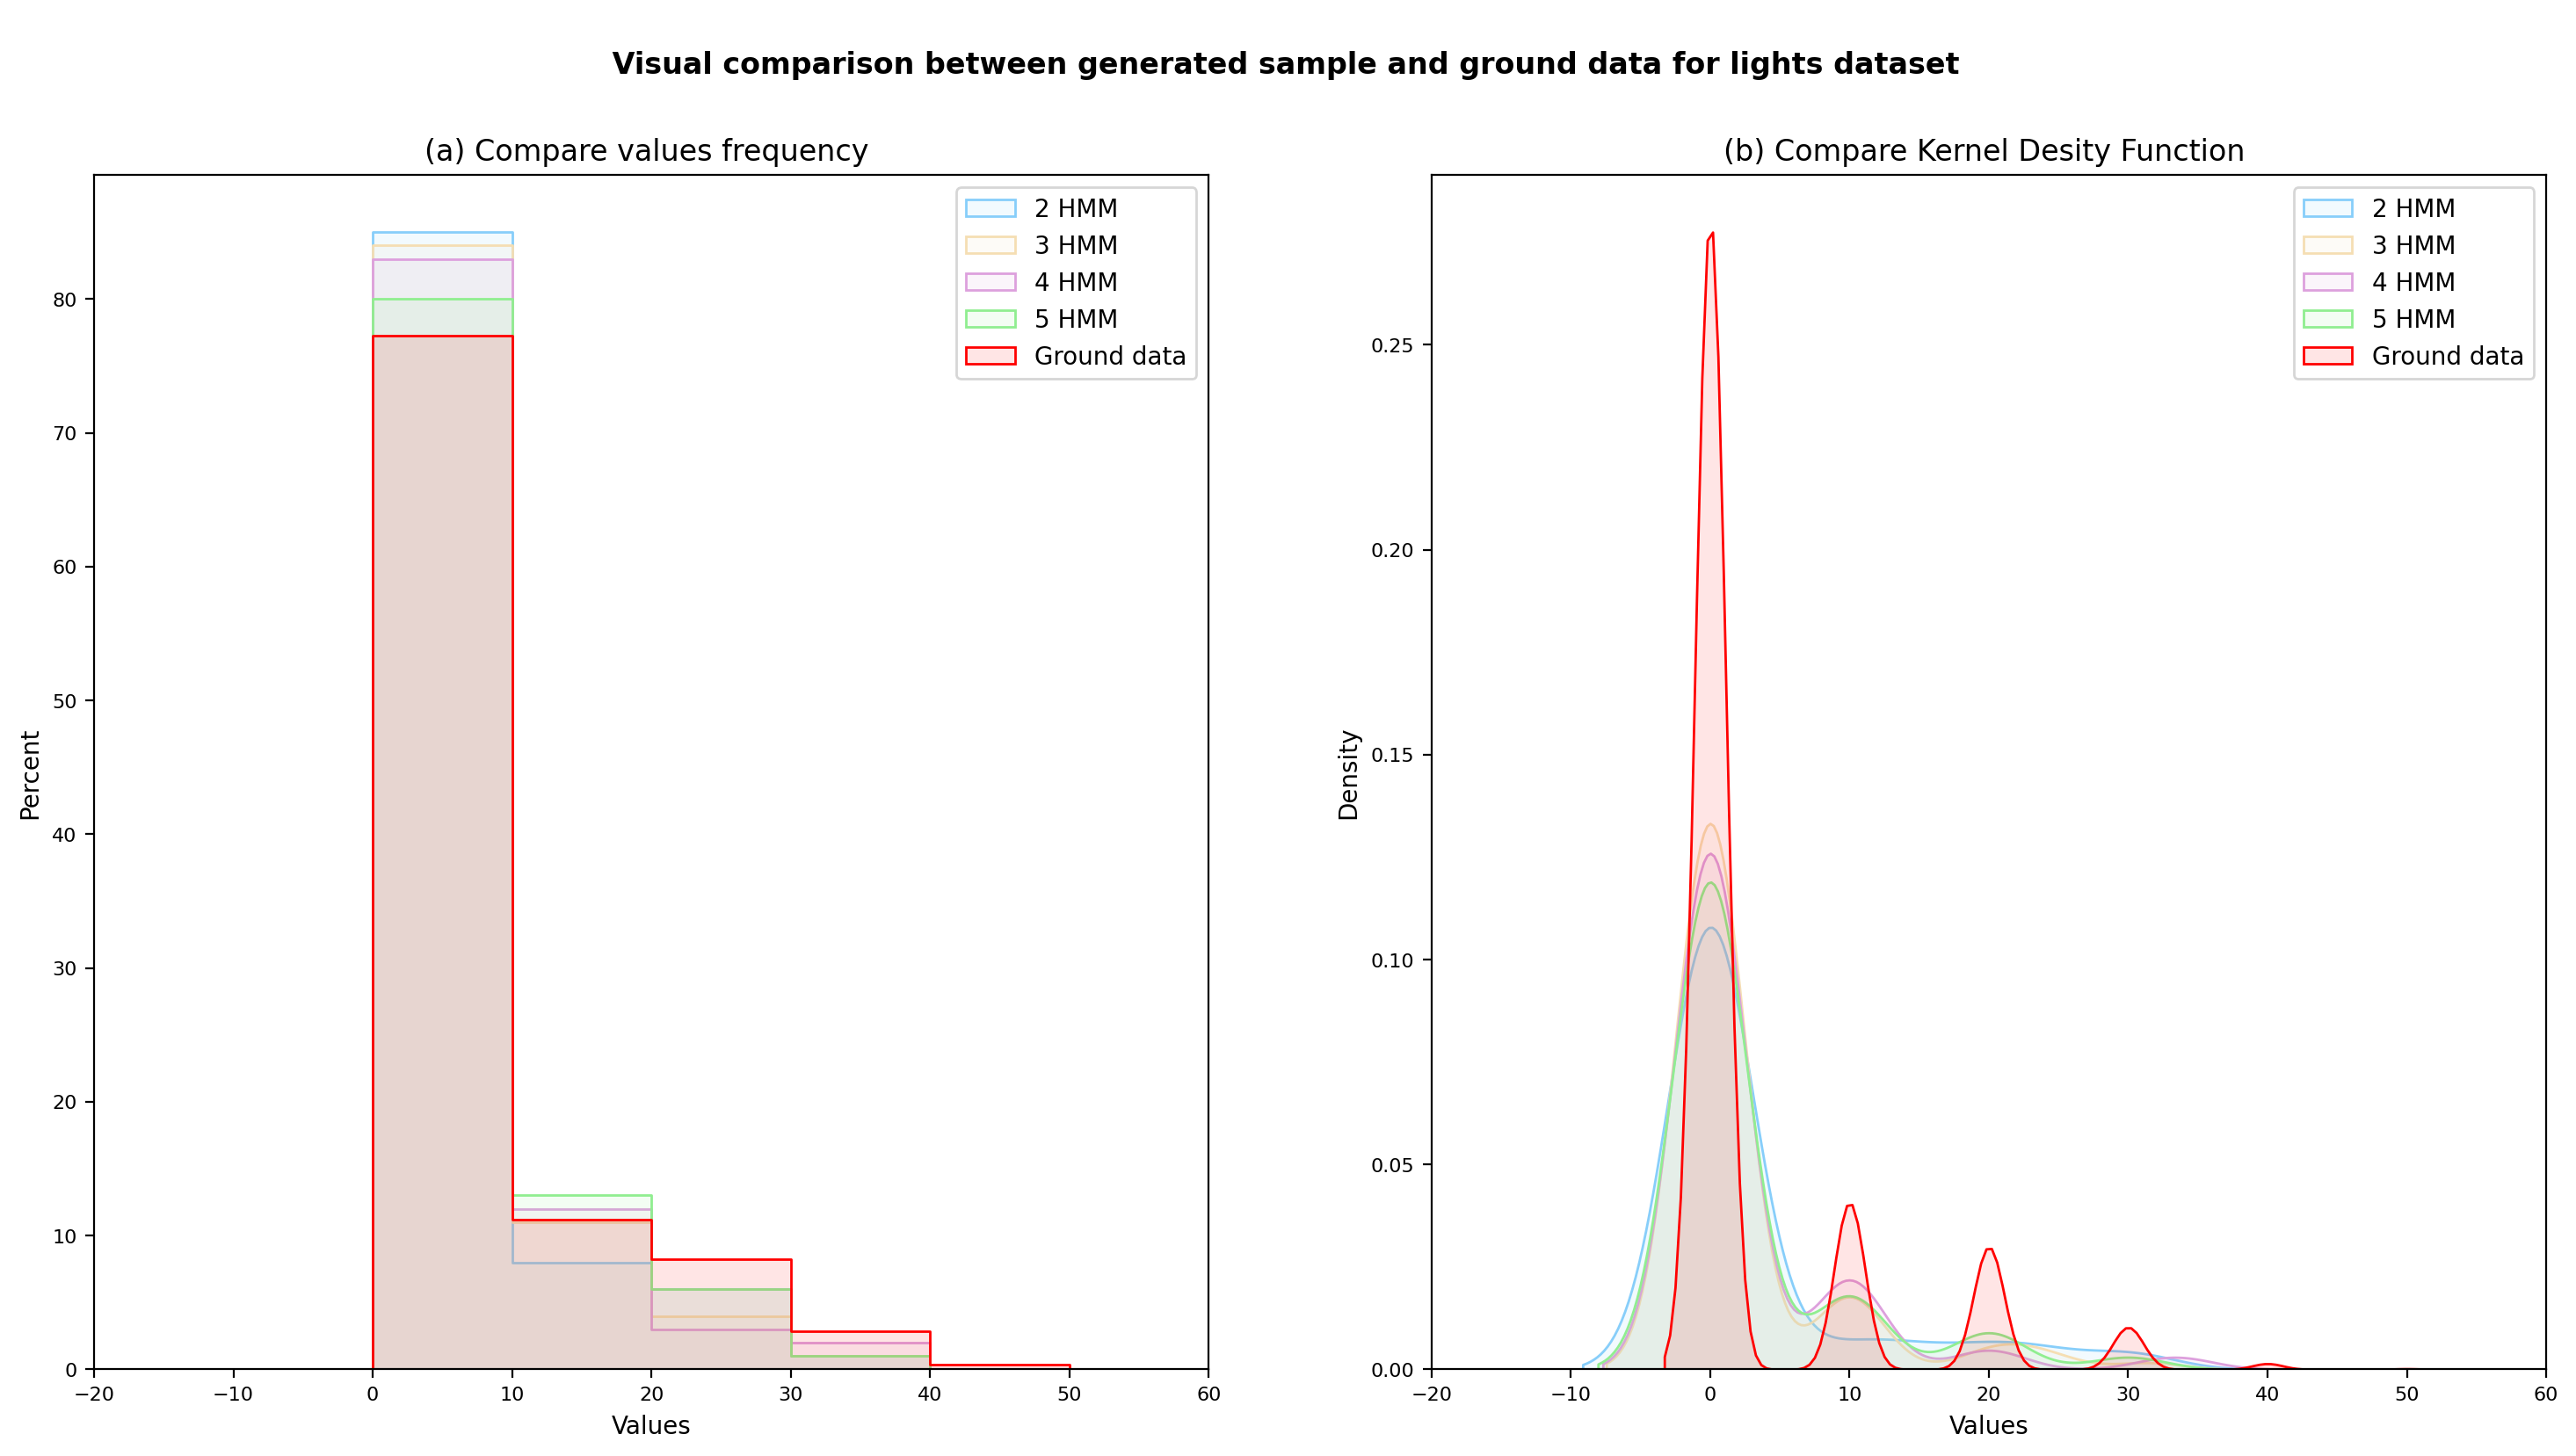

In [ ]:
# Dataset: APPLIANCES
qualitativeAnalysis (L_sampleX, lights_dataset, "lights")

The figures above provide useful information to identify which sample data sequence is more consistent with the ground data sequence.

Considering the **Appliaces** dataset we can say that the curves of the sequences generated with HMMs with 3 and 4 components behave more like the real curve, while the curves generated with HMMs with 2 and 5 components seem to deviate more from real curve.

As far as the **Lights** dataset is concerned, we can easily deduce that the curve less similar to the real curve is the one derived using a simple model with only two hidden states. It becomes more difficult to say which of the remaining curves is the most similar to the real one.

It should also be noted that these plots, comparing a single sample data sequence with the ground data sequence, are sensitive to the specific sample data used; in fact, the curves of two sample sequences generated from the same HMM may behave differently. So the above conclusions were drawn from the analysis of multiple graphs.

### **5.2 Quantitative comparison: KL divergence and others metrics**

This section provides a quantitative method for determinate, in a more rigorously way,  which sequence of sample data behaves most like ground data.

The `quantitativeAnalysis()` function transforms the data sequences (both sample data and ground data) into histograms such that the result is the probability density function at each bin (normalised such that the integral over the range is 1). 
More specifically, for each available HMMs the ground data histogram is compared with 50 sequences generated by that model based on specific metrics and the average value of the metrics is taken as the final result. 


The similarity between histograms was studied on the basis of five different metrics, which are Correlation, Intersection, Chi-square, Bhattacharyya and KL divergence:
- For the Correlation and Intersection methods, the higher the metric, the more accurate is the match;
- For Chi-square, Bhattacharyya and KL-divergence methods, the lower the metric, the more accurate is the match. 





In [ ]:
def quantitativeAnalysis (sampleX, dataset, temp):

  # create a matrix to store metrics value
  metrics = np.zeros((4,5))
  
  # create histogram of density for the ground data
  ground_hist, _ = np.histogram(dataset[temp], bins=200, density=True) 
  ground_hist = np.array(ground_hist, dtype="float32")

  for i in range(4): # for each trained HMMs
    # cosider 50 sequence of sample data generated with each HMMs
    for j in range(50): # for each one of these 50 sequences

      # create histogram of density for sample data
      sample = pd.DataFrame(sampleX[i][j], columns=[temp])
      sample_hist, _ = np.histogram(sample[temp], bins=200, density=True) 
      sample_hist = np.array(sample_hist, dtype="float32")

      # compare sample data and ground data with different metrics
      corr   = cv2.compareHist(ground_hist, sample_hist,  cv2.HISTCMP_CORREL)
      chisqr = cv2.compareHist(ground_hist, sample_hist,  cv2.HISTCMP_CHISQR)
      bhatta = cv2.compareHist(ground_hist, sample_hist,  cv2.HISTCMP_BHATTACHARYYA)
      inters = cv2.compareHist(ground_hist, sample_hist,  cv2.HISTCMP_INTERSECT)   
      kldiv  = cv2.compareHist(ground_hist, sample_hist,  cv2.HISTCMP_KL_DIV)
      
      # update matrix of metrics value 
      metrics[i] += np.array([corr, chisqr, bhatta, inters, kldiv])
    
    # take the mean value of metrics for the 50 considered sequences 
    metrics[i] = metrics[i] / 50
  
  #show metrics vale in a dataframe
  metricsM = pd.DataFrame(metrics, index = ["groud data - 2 hs HMM sample data",
                      "groud data - 3 hs HMM sample data", 
                      "groud data - 4 hs HMM sample data", 
                      "groud data - 5 hs HMM sample data", ],
                      columns=["Correlation", "ChiSquare", "Bhattacharyya", "Intersetc", "KL divergence"])

  return metricsM

In [ ]:
# Dataset: APPLIANCES
A_metrics = quantitativeAnalysis(A_sample_X, appliances_dataset, "Appliances")
display(A_metrics)

Correlation   ChiSquare  Bhattacharyya  \
groud data - 2 hs HMM sample data    -0.005005   49.044352       0.873965   
groud data - 3 hs HMM sample data     0.253541  254.012617       0.748064   
groud data - 4 hs HMM sample data     0.321548  119.751223       0.710002   
groud data - 5 hs HMM sample data     0.335848  217.833680       0.704743   

                                   Intersetc  KL divergence  
groud data - 2 hs HMM sample data   0.027357       2.690246  
groud data - 3 hs HMM sample data   0.072810       1.554947  
groud data - 4 hs HMM sample data   0.088163       1.040400  
groud data - 5 hs HMM sample data   0.090650       0.958454

In [ ]:
# Dataset: LIGHTS
L_metrics = quantitativeAnalysis(L_sample_X, lights_dataset, "lights")
display(L_metrics)

Correlation   ChiSquare  Bhattacharyya  \
groud data - 2 hs HMM sample data     0.613123   47.506135       0.650346   
groud data - 3 hs HMM sample data     0.968285   42.328861       0.485666   
groud data - 4 hs HMM sample data     0.941922   29.175013       0.494222   
groud data - 5 hs HMM sample data     0.940135  677.319221       0.505605   

                                   Intersetc  KL divergence  
groud data - 2 hs HMM sample data   1.415580      15.008510  
groud data - 3 hs HMM sample data   2.216593      12.174161  
groud data - 4 hs HMM sample data   2.208009      12.341019  
groud data - 5 hs HMM sample data   2.209778      12.523499

The results shown in tables agree with conclusions reached by looking at the graphs obtained in the quantitative analysis. 

Furthermore, it is possible to formalise new conclusions.

For **Appliances** dataset the metrics values suggest that sequences behaving most like the ground data are those derived from a 4-hidden states model (all metrics agree on this result).

For the **Lights** dataset the metrics values suggest that the best candidate sequences are those derived from 3 and 4 hidden state models; although with small differences, some metrics give preference to the former and others to the latter.




---


# **6. Conclusion and further developments**

Once all the phases of this study have been completed, the most salient conclusions can be reported below.

The application of Viterbi has highlighted the existence of different levels of consumption to which the data in our datasets belong. \
The sampling of new data sequences makes possible to find the model able to generate sequences with a distribution most similar to the actual distribution.\
 The best model, able to approximate in an optimal way the distribution of the data both in the lights dataset and in the appliances dataset, is an Hidden Markov Model with 4 hidden states. \
However, the values of the metrics computed in section 5.2 show that this HMM with four components is able to approximate the distribution of new data more accurately in the lights dataset than in the appliances dataset. 

Some possible future developments are the following:
- Apply Viterbi on a larger data sequence (e.g. 2 months of recordings) and check if the relation between hidden state and consumption level remains unchanged. 
- Generate data sequences consisting of more than 100 points and check whether the  4-hidden state model is yet the best one (the one able to appoximate better the real data distribution). 





---


# **7. Sources and references**


*   [The Kullback–Leibler divergence between discrete probability distributions](https://blogs.sas.com/content/iml/2020/05/26/kullback-leibler-divergence-discrete.html#:~:text=That%20is%2C%20the%20Kullback%E2%80%93Leibler,in%20the%20support%20of%20f.&text=Notice%20that%20if%20the%20two,the%20two%20distributions%20are%20equal.)
*   [OpenCV, Histogram comaprison](https://docs.opencv.org/3.4/d6/dc7/group__imgproc__hist.html)
* [Seaborn, Kernel Density Estimation](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)
* [Hidden Markov Model with hmmlearn](https://hmmlearn.readthedocs.io/en/latest/)
*[Theory of Hidden Markov Model](https://web.stanford.edu/~jurafsky/slp3/A.pdf)



